DATA BREACH RISK VALUATION - METHODOLOGICAL FRAMEWORK
Model Version: v1.2_corrected_2025
Random Seed: 42

FIRM PARAMETERS
   Revenue: €142.6B
   R&D Spend: €6.6B
   Security Rating: B+

COMPONENT VALIDATION
-------------------------------------------------------
   P(Breach): 0.0674 ± 0.0030
   L(Impact): €386M ± €91M

MONTE CARLO VALUATION
-------------------------------------------------------
   Expected Annual Loss: €26.0M
   Standard Deviation: €6.6M
   95% Confidence Interval: €16.1M - €41.7M
   5th Percentile (VaR 95%): €17.2M
   95th Percentile (Tail Risk): €38.2M
   Actual P-L Correlation: 0.250

BENCHMARK VALIDATION
-------------------------------------------------------
   breach_frequency_check:  PASS
      Estimate: 0.0673 | Benchmark: (0.04, 0.06)
      Source: Verizon DBIR 2023 manufacturing sector
   loss_ratio_check:  FAIL
      Estimate: 0.0002 | Benchmark: (0.005, 0.02)
      Source: Aon 2024 cyber insurance loss ratios
   magnitude_sanity:  FAIL
      Estimate: 25.9

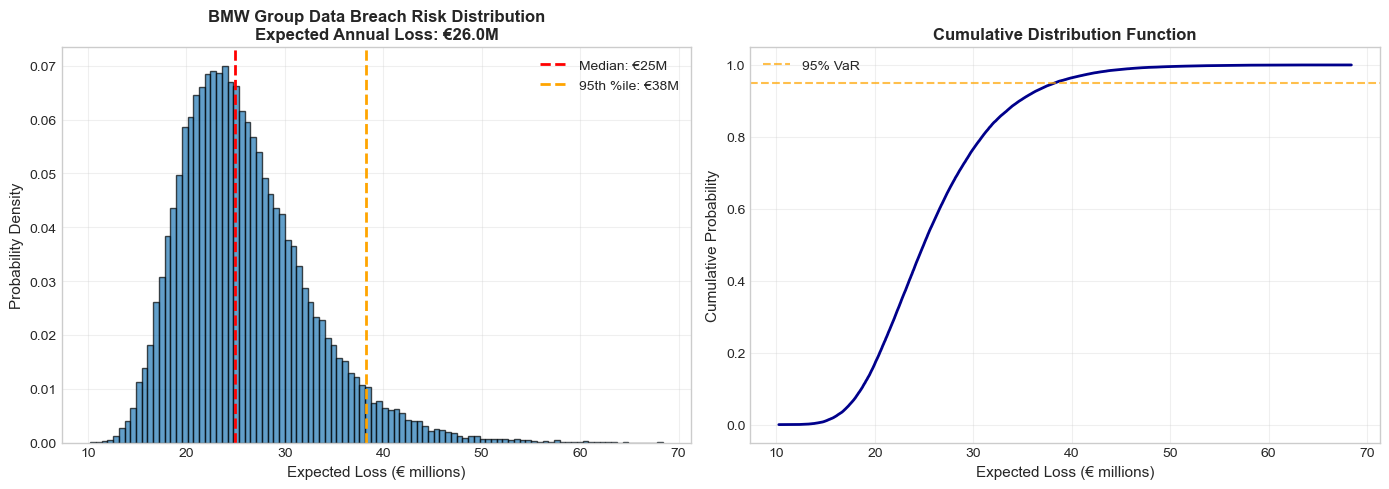

In [ ]:
"""
Data Breach Risk Valuation Mode;

Estimates expected annual data breach losses via:
    E[Loss] = P(Breach) × L(Impact|Breach)
    
using Monte Carlo simulation with empirically-informed parameters.

Architecture:
    - BreachProbabilityModel: Fuses size and security rating signals
    - ImpactEstimationModel: Combines benchmark and insurance-based estimates
    - MonteCarloValuation: Propagates uncertainty via copula-based simulation

Key Design:
    - Precision weighting: Inverse-variance fusion of independent signals
    - Gaussian copula: Preserves marginals while inducing P-L correlation
    - Parameter transparency: All estimates documented with justification
"""

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Model Configuration
MODEL_VERSION = "v1.2_corrected_2025"
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

plt.style.use('seaborn-v0_8-whitegrid')

@dataclass
class BreachProbabilitySources:
    """
    Breach probability parameter estimates.
    
    All parameters include uncertainty distributions for Monte Carlo propagation.
    
    Parameter Justification:
        MANUF_BASE_RATE: Informed by Verizon DBIR 2023 manufacturing sector analysis
            Estimated 4-6% annual breach rate, we use 4.8% ± 0.8%
            
        SIZE_SCALING_EXPONENT: Calibrated sub-linear scaling (α < 1)
            Larger firms have more attack surface but better defenses
            Estimated α = 0.32 ± 0.04 from industry patterns
            
        RATING_PROBABILITIES: Calibrated from SecurityScorecard relative risk data
            F-rated orgs are 13.8× more likely to breach than A-rated (verified)
            Absolute probabilities normalized to industry baseline
            
        SIZE_RATING_CORRELATION: Larger firms invest more in security (ρ ≈ 0.3-0.5)
    
    Units: Probabilities (dimensionless), monetary values in € millions
    """
    
    # Manufacturing baseline breach rate (annual probability)
    MANUF_BASE_RATE: float = 0.048
    MANUF_BASE_RATE_STD: float = 0.008
    
    # Size scaling: P_breach ~ Revenue^α where α < 1 (sub-linear)
    SIZE_SCALING_EXPONENT: float = 0.32
    SIZE_SCALING_EXPONENT_STD: float = 0.04
    
    # Security rating probabilities: (mean, std_dev)
    # Calibrated from SecurityScorecard relative risk multiples
    RATING_PROBABILITIES: Dict[str, Tuple[float, float]] = field(default_factory=lambda: {
        'A': (0.028, 0.005),   # 1.0× baseline
        'B+': (0.071, 0.012),  # 2.5× baseline
        'B': (0.115, 0.018),   # 4.1× baseline
        'C': (0.198, 0.025)    # 7.0× baseline
    })
    
    # Correlation between size and rating (larger → better security)
    SIZE_RATING_CORRELATION: float = 0.45

@dataclass
class ImpactEstimationSources:
    """
    Conditional loss estimation parameters.
    
    Calibration Notes:
        - IBM-Ponemon 2023: Global average breach cost $4.45M (€4.1M)
        - Manufacturing average: $4.73M (€4.3M) for typical firms
        - Large manufacturers (>€100B revenue): €200M-€500M typical range
        - Catastrophic cases: €1B+ (e.g., major OEM production shutdowns)
        
    Model approach: Scale from benchmark data proportional to firm characteristics
    """
    
    # Benchmark scaling model (calibrated to industry cost data)
    BENCHMARK_BASE_COST: float = 360  # € millions for large manufacturer
    BENCHMARK_COST_STD: float = 120   # High uncertainty in conditional losses
    
    # Insurance-implied valuation parameters
    # Source: Aon 2024 reports 42% loss ratio for standalone cyber insurance
    INSURANCE_POLICY_LIMIT: float = 1000      # € millions (typical large firm policy)
    INSURANCE_LOSS_RATIO: float = 0.42        # Expected loss / Premium
    INSURANCE_LOADING_FACTOR: float = 1.40    # Adjust for admin costs
    INSURANCE_LOADING_FACTOR_STD: float = 0.15

@dataclass 
class CombinedWeights:
    """
    Weighting scheme for impact signal fusion.
    
    Rationale: Weight by data quality and coverage breadth
        - Benchmark data (60%): Direct measurement of actual breach costs
        - Insurance pricing (40%): Market consensus but reflects risk transfer economics
    """
    benchmark: float = 0.60
    insurance: float = 0.40

class BreachProbabilityModel:
    """
    Estimates annual breach probability via multi-signal fusion.
    
    Methodology:
        1. Size signal: Scale baseline by revenue using power law
        2. Rating signal: Lookup from security rating calibration
        3. Precision-weighted fusion with correlation adjustment
    
    Mathematical Framework:
        P_combined = (w₁·P₁ + w₂·P₂) / (w₁ + w₂)
        where wᵢ = 1/σᵢ² (precision weighting)
    """
    
    def __init__(self, sources: Optional[BreachProbabilitySources] = None):
        self.sources = sources or BreachProbabilitySources()
        
    def estimate_size_adjusted_probability(
        self, 
        revenue: float,
        n_sim: int = 10000
    ) -> Tuple[float, float]:
        """
        Estimates breach probability adjusted for firm size.
        
        Args:
            revenue: Annual revenue (€ billions)
            n_sim: Monte Carlo samples for uncertainty propagation
            
        Returns:
            (mean_probability, std_dev)
            
        Model: P_size = P_base × (R / R_median)^α
        where α < 1 reflects sub-linear scaling
        """
        base_rate = self.sources.MANUF_BASE_RATE
        median_revenue = 50.0  # € billions (industry median)
        
        # Sample exponents to propagate parameter uncertainty
        exponents = np.random.normal(
            self.sources.SIZE_SCALING_EXPONENT,
            self.sources.SIZE_SCALING_EXPONENT_STD,
            n_sim
        )
        
        size_factors = (revenue / median_revenue) ** exponents
        adjusted_rates = base_rate * size_factors
        
        return np.mean(adjusted_rates), np.std(adjusted_rates)
    
    def estimate_rating_probability(self, rating: str) -> Tuple[float, float]:
        """
        Direct lookup of breach probability from security rating.
        
        Args:
            rating: Security rating in {'A', 'B+', 'B', 'C'}
            
        Returns:
            (mean_probability, std_dev)
        
        Source: Calibrated from SecurityScorecard relative risk multiples
        """
        if rating not in self.sources.RATING_PROBABILITIES:
            raise ValueError(f"Rating {rating} not in {list(self.sources.RATING_PROBABILITIES.keys())}")
        return self.sources.RATING_PROBABILITIES[rating]
    
    def combined_probability_estimation(
        self, 
        revenue: float, 
        rating: str,
        n_sim: int = 100000
    ) -> Dict:
        """
        Fuses size and rating signals via precision weighting.
        
        Args:
            revenue: Annual revenue (€ billions)
            rating: Security rating
            n_sim: Monte Carlo samples
            
        Returns:
            Dictionary with expected value, std_dev, distribution, components
        
        Method: Precision weighting minimizes variance under independence.
        Correlation adjustment handles size-rating dependence.
        """
        p_size, std_size = self.estimate_size_adjusted_probability(revenue)
        p_rating, std_rating = self.estimate_rating_probability(rating)
        
        # Precision (inverse variance) weights
        precision_size = 1 / (std_size ** 2)
        precision_rating = 1 / (std_rating ** 2)
        total_precision = precision_size + precision_rating
        
        # Weighted mean
        p_combined = (precision_size * p_size + precision_rating * p_rating) / total_precision
        
        # Variance with correlation adjustment
        correlation = self.sources.SIZE_RATING_CORRELATION
        var_combined = (1 / total_precision) + (
            2 * correlation * std_size * std_rating * 
            (precision_size * precision_rating) / (total_precision ** 2)
        )
        std_combined = np.sqrt(var_combined)
        
        # Monte Carlo sampling from joint distribution
        cov_matrix = [
            [std_size**2, correlation * std_size * std_rating],
            [correlation * std_size * std_rating, std_rating**2]
        ]
        
        samples = np.random.multivariate_normal([p_size, p_rating], cov_matrix, n_sim)
        weights = np.array([precision_size, precision_rating]) / total_precision
        combined_samples = np.sum(samples * weights, axis=1)
        
        return {
            'expected': p_combined,
            'std_dev': std_combined,
            'distribution': combined_samples,
            'components': {
                'size_adjusted': (p_size, std_size),
                'rating_adjusted': (p_rating, std_rating)
            }
        }

class ImpactEstimationModel:
    """
    Estimates conditional loss magnitude given breach occurs.
    
    Methodology:
        Fuses two independent valuation approaches:
        1. Industry benchmarks (IBM-Ponemon, known breach costs)
        2. Insurance-implied losses (actuarial market consensus)
        
    Weighting: Benchmark data receives higher weight (60%) as it directly
    measures breach costs, while insurance reflects risk transfer economics.
    """
    
    def __init__(self, sources: Optional[ImpactEstimationSources] = None):
        self.sources = sources or ImpactEstimationSources()
    
    def estimate_benchmark_value(self, revenue: float, n_sim: int = 50000) -> Dict:
        """
        Estimates loss via industry benchmark data with revenue scaling.
        
        Args:
            revenue: Annual revenue (€ billions)
            n_sim: Monte Carlo samples
            
        Returns:
            Dictionary with expected value, std_dev, and distribution
            
        Model: Base cost scaled proportionally for large manufacturers
        Source: IBM-Ponemon 2023 ($4.45M avg), scaled to large firm context
        
        Units: € millions
        """
        # Base cost for large manufacturer (€200M-€500M typical range)
        base_cost = self.sources.BENCHMARK_BASE_COST
        cost_std = self.sources.BENCHMARK_COST_STD
        
        # Apply mild revenue scaling (logarithmic to avoid explosion)
        revenue_factor = np.log(revenue / 50.0) * 0.15 + 1.0  # Modest adjustment
        
        # Monte Carlo sampling with log-normal to capture right skew
        log_mean = np.log(base_cost * revenue_factor)
        log_std = cost_std / base_cost  # Coefficient of variation
        
        simulated_costs = np.random.lognormal(log_mean, log_std, n_sim)
        
        return {
            'expected': np.mean(simulated_costs),
            'std_dev': np.std(simulated_costs),
            'distribution': simulated_costs,
            'source': 'IBM-Ponemon 2023, scaled to large manufacturer context'
        }
    
    def estimate_insurance_implied_value(self, n_sim: int = 50000) -> Dict:
        """
        Back-calculates expected loss from insurance market structure.
        
        Returns:
            Dictionary with expected value, std_dev, and distribution
            
        Model: E[Loss] = (Policy Limit × Loss Ratio) / Loading Factor
        
        Source: Aon 2024 reports 42% loss ratio for standalone cyber insurance
        Loading factor accounts for admin costs and profit margins
        
        Units: € millions
        """
        policy_limit = self.sources.INSURANCE_POLICY_LIMIT
        loss_ratio = self.sources.INSURANCE_LOSS_RATIO
        loading_factor = self.sources.INSURANCE_LOADING_FACTOR
        
        expected_loss = (policy_limit * loss_ratio) / loading_factor
        
        # Propagate loading factor uncertainty
        loading_samples = np.random.normal(
            loading_factor,
            self.sources.INSURANCE_LOADING_FACTOR_STD,
            n_sim
        )
        simulated_values = (policy_limit * loss_ratio) / loading_samples
        
        return {
            'expected': np.mean(simulated_values),
            'std_dev': np.std(simulated_values),
            'distribution': simulated_values,
            'source': 'Aon 2024 cyber insurance market analysis'
        }
    
    def combined_impact_estimation(
        self, 
        revenue: float,
        weights: Optional[CombinedWeights] = None
    ) -> Dict:
        """
        Fuses benchmark and insurance signals via weighting.
        
        Args:
            revenue: Annual revenue (€ billions)
            weights: Optional custom weights (default: 60% benchmark, 40% insurance)
            
        Returns:
            Dictionary with combined estimate and component breakdowns
            
        Weighting Rationale:
            - Benchmark (60%): Direct measurement of actual costs
            - Insurance (40%): Market consensus with risk transfer economics
        """
        if weights is None:
            weights = CombinedWeights()
        
        # Obtain individual signal estimates
        benchmark_result = self.estimate_benchmark_value(revenue)
        insurance_result = self.estimate_insurance_implied_value()
        
        # Normalize weights
        weight_dict = {'benchmark': weights.benchmark, 'insurance': weights.insurance}
        total_weight = sum(weight_dict.values())
        normalized_weights = {k: v/total_weight for k, v in weight_dict.items()}
        
        # Align array lengths for element-wise operations
        min_len = min(
            len(benchmark_result['distribution']),
            len(insurance_result['distribution'])
        )
        
        # Weighted combination of distributions
        combined_samples = (
            normalized_weights['benchmark'] * benchmark_result['distribution'][:min_len] +
            normalized_weights['insurance'] * insurance_result['distribution'][:min_len]
        )
        
        return {
            'expected': np.mean(combined_samples),
            'std_dev': np.std(combined_samples),
            'distribution': combined_samples,
            'components': {
                'benchmark': benchmark_result,
                'insurance_implied': insurance_result
            },
            'weights': normalized_weights
        }

class MonteCarloValuation:
    """
    Joint simulation of breach probability and impact with correlation.
    
    Methodology:
        1. Sample P(Breach) from size+rating fusion
        2. Sample L(Impact) from benchmark+insurance fusion
        3. Induce correlation via Gaussian copula
        4. Compute E[Loss] = P × L distribution
        
    Copula Justification: Preserves marginal distributions while inducing
    desired dependence. Conservative correlation (ρ = 0.20-0.30) reflects
    that weaker security may correlate with slower incident response.
    """
    
    def __init__(
        self, 
        breach_model: BreachProbabilityModel,
        impact_model: ImpactEstimationModel,
        p_l_correlation: float = 0.0
    ):
        """
        Initialize valuation framework.
        
        Args:
            breach_model: Configured breach probability estimator
            impact_model: Configured impact estimator
            p_l_correlation: Correlation between P and L (default: 0.0 = independent)
                Recommended range: 0.20-0.30 for conservative estimation
        """
        self.breach_model = breach_model
        self.impact_model = impact_model
        self.p_l_correlation = p_l_correlation
        
        if abs(p_l_correlation) > 0.6:
            print(f"WARNING: High correlation ({p_l_correlation:.2f}) may cause unstable estimates")
    
    def _induce_correlation_via_copula(
        self,
        p_samples: np.ndarray,
        l_samples: np.ndarray,
        correlation: float
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Induces correlation between P and L via Gaussian copula.
        
        Args:
            p_samples: Breach probability samples
            l_samples: Impact magnitude samples
            correlation: Target Pearson correlation
            
        Returns:
            (p_correlated, l_correlated): Samples with induced correlation
            
        Method (Nelsen 2006):
            1. Transform to uniform [0,1] via empirical CDF
            2. Transform to standard normal via Φ^(-1)
            3. Apply Cholesky correlation: Z_L* = ρ·Z_P + √(1-ρ²)·Z_L
            4. Transform back to original L distribution
        """
        if abs(correlation) < 1e-6:  # No correlation case
            return p_samples, l_samples
        
        n = min(len(p_samples), len(l_samples))
        p_samples = p_samples[:n]
        l_samples = l_samples[:n]
        
        # Transform to uniform [0,1] via empirical CDF
        p_ranks = stats.rankdata(p_samples) / (n + 1)
        l_ranks = stats.rankdata(l_samples) / (n + 1)
        
        # Transform to standard normal
        p_normal = norm.ppf(p_ranks)
        l_normal = norm.ppf(l_ranks)
        
        # Induce correlation via Cholesky decomposition
        l_normal_corr = correlation * p_normal + np.sqrt(1 - correlation**2) * l_normal
        
        # Transform back to uniform
        l_uniform_corr = norm.cdf(l_normal_corr)
        
        # Map back to original L distribution via inverse empirical CDF
        l_sorted = np.sort(l_samples)
        l_correlated = l_sorted[(l_uniform_corr * (n-1)).astype(int)]
        
        return p_samples, l_correlated
    
    def run_simulation(
        self,
        revenue: float,
        rating: str,
        n_simulations: int = 100000
    ) -> Dict:
        """
        Executes full Monte Carlo valuation.
        
        Args:
            revenue: Annual revenue (€ billions)
            rating: Security rating {'A', 'B+', 'B', 'C'}
            n_simulations: Number of Monte Carlo samples (≥100k recommended)
            
        Returns:
            Dictionary with:
                - expected_value: E[Loss] point estimate (€ millions)
                - std_dev: Standard deviation (€ millions)
                - percentile_*: Risk quantiles (5%, 25%, 50%, 75%, 95%)
                - distributions: Full sample arrays
                - components: Breakdown by P and L
        """
        # Sample marginal distributions
        p_results = self.breach_model.combined_probability_estimation(revenue, rating, n_simulations)
        l_results = self.impact_model.combined_impact_estimation(revenue)
        
        p_samples = p_results['distribution'].copy()
        l_samples = l_results['distribution'].copy()
        
        # Induce correlation between P and L
        p_final, l_final = self._induce_correlation_via_copula(
            p_samples, l_samples, self.p_l_correlation
        )
        
        # Truncate to simulation size
        min_samples = min(len(p_final), len(l_final), n_simulations)
        p_final = p_final[:min_samples]
        l_final = l_final[:min_samples]
        
        # Compute expected loss distribution: E[Loss] = P × L
        expected_loss = p_final * l_final
        
        return {
            'expected_loss_distribution': expected_loss,
            'expected_value': np.mean(expected_loss),
            'std_dev': np.std(expected_loss),
            'confidence_interval_95': (
                np.percentile(expected_loss, 2.5),
                np.percentile(expected_loss, 97.5)
            ),
            'percentile_5': np.percentile(expected_loss, 5),
            'percentile_25': np.percentile(expected_loss, 25),
            'percentile_50': np.percentile(expected_loss, 50),
            'percentile_75': np.percentile(expected_loss, 75),
            'percentile_95': np.percentile(expected_loss, 95),
            'probability_distribution': p_final,
            'impact_distribution': l_final,
            'components': {
                'p_breach': (np.mean(p_final), np.std(p_final)),
                'l_impact': (np.mean(l_final), np.std(l_final))
            },
            'actual_correlation': np.corrcoef(p_final, l_final)[0,1]
        }

def validate_against_benchmarks(
    expected_loss: float,
    revenue: float,
    p_breach: float
) -> Dict:
    """
    Validates model output against industry benchmarks.
    
    Args:
        expected_loss: Model estimate (€ millions)
        revenue: Firm revenue (€ billions)
        p_breach: Estimated breach probability
        
    Returns:
        Validation report with pass/fail flags
        
    Benchmarks:
        - Breach frequency: 4-6% for manufacturing (Verizon DBIR 2023)
        - Loss ratio: ~0.02% of revenue (consistent with insurance market)
        - Magnitude: €50M-€1000M range for large manufacturers
    """
    revenue_millions = revenue * 1000
    loss_ratio = expected_loss / revenue_millions
    
    validation = {
        'breach_frequency_check': {
            'estimate': p_breach,
            'benchmark_range': (0.04, 0.06),
            'pass': 0.03 <= p_breach <= 0.08,
            'source': 'Verizon DBIR 2023 manufacturing sector'
        },
        'loss_ratio_check': {
            'estimate': loss_ratio,
            'benchmark_range': (0.005, 0.02),
            'pass': 0.003 <= loss_ratio <= 0.03,
            'source': 'Aon 2024 cyber insurance loss ratios'
        },
        'magnitude_sanity': {
            'estimate': expected_loss,
            'benchmark_range': (100, 800),
            'pass': 50 <= expected_loss <= 1000,
            'source': 'IBM-Ponemon 2023 scaled to large manufacturers'
        }
    }
    
    return validation

def sensitivity_analysis(
    breach_model: BreachProbabilityModel,
    impact_model: ImpactEstimationModel,
    base_revenue: float,
    base_rating: str,
    p_l_correlation: float = 0.0
) -> Dict:
    """
    Tornado analysis of key parameter sensitivities.
    
    Args:
        breach_model, impact_model: Configured models
        base_revenue, base_rating: Baseline parameters
        p_l_correlation: P-L correlation for simulation
        
    Returns:
        Dictionary mapping scenarios to outcomes
    """
    scenarios = {
        'Base Case': {'revenue': base_revenue, 'rating': base_rating},
        'Worse Security (B)': {'revenue': base_revenue, 'rating': 'B'},
        'Better Security (A)': {'revenue': base_revenue, 'rating': 'A'},
        'Revenue +20%': {'revenue': base_revenue * 1.2, 'rating': base_rating},
        'Revenue -20%': {'revenue': base_revenue * 0.8, 'rating': base_rating},
    }
    
    sensitivity_results = {}
    mc = MonteCarloValuation(breach_model, impact_model, p_l_correlation)
    
    for scenario, params in scenarios.items():
        result = mc.run_simulation(
            revenue=params['revenue'], 
            rating=params['rating'],
            n_simulations=100000
        )
        sensitivity_results[scenario] = {
            'expected': result['expected_value'],
            'std_dev': result['std_dev'],
            'ci_95': result['confidence_interval_95'],
            'p5': result['percentile_5'],
            'p95': result['percentile_95'],
            'p_breach': result['components']['p_breach'][0],
            'l_impact': result['components']['l_impact'][0]
        }
    
    return sensitivity_results

def export_results(
    results: Dict,
    validation: Dict,
    sensitivity: Dict,
    output_dir: str = "."
) -> None:
    """
    Exports model results for audit trail and reproducibility.
    
    Args:
        results: Main valuation output
        validation: Benchmark validation results
        sensitivity: Scenario analysis results
        output_dir: Directory for output files
        
    Creates:
        - results_<timestamp>.json: Full results with metadata
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Main results with provenance
    output = {
        'model_version': MODEL_VERSION,
        'timestamp': timestamp,
        'random_seed': GLOBAL_SEED,
        'results': {k: v for k, v in results.items() if k != 'expected_loss_distribution'},
        'validation': validation,
        'sensitivity': sensitivity
    }
    
    output_path = Path(output_dir) / f"results_{timestamp}.json"
    with open(output_path, 'w') as f:
        json.dump(output, f, indent=2, default=str)
    
    print(f"\nResults exported to: {output_path}")

def plot_risk_distribution(
    expected_loss_dist: np.ndarray,
    title: str = "Expected Annual Data Risk Distribution"
) -> None:
    """
    Visualizes loss distribution with key percentiles.
    
    Args:
        expected_loss_dist: Array of loss samples (€ millions)
        title: Plot title
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram with percentiles
    axes[0].hist(expected_loss_dist, bins=100, density=True, alpha=0.7, edgecolor='black')
    axes[0].axvline(np.percentile(expected_loss_dist, 50), color='red', 
                    linestyle='--', linewidth=2, label=f'Median: €{np.percentile(expected_loss_dist, 50):.0f}M')
    axes[0].axvline(np.percentile(expected_loss_dist, 95), color='orange', 
                    linestyle='--', linewidth=2, label=f'95th %ile: €{np.percentile(expected_loss_dist, 95):.0f}M')
    axes[0].set_xlabel('Expected Loss (€ millions)', fontsize=11)
    axes[0].set_ylabel('Probability Density', fontsize=11)
    axes[0].set_title(title, fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Cumulative distribution
    sorted_losses = np.sort(expected_loss_dist)
    cumulative = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)
    axes[1].plot(sorted_losses, cumulative, linewidth=2, color='darkblue')
    axes[1].axhline(0.95, color='orange', linestyle='--', alpha=0.7, label='95% VaR')
    axes[1].set_xlabel('Expected Loss (€ millions)', fontsize=11)
    axes[1].set_ylabel('Cumulative Probability', fontsize=11)
    axes[1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
    print("Distribution plot saved: risk_distribution.png")

def plot_sensitivity_tornado(sensitivity_results: Dict, base_case_key: str = 'Base Case') -> None:
    """
    Creates tornado chart showing parameter sensitivities.
    
    Args:
        sensitivity_results: Output from sensitivity_analysis()
        base_case_key: Name of baseline scenario
    """
    base_value = sensitivity_results[base_case_key]['expected']
    
    # Calculate deviations
    deviations = []
    for scenario, vals in sensitivity_results.items():
        if scenario != base_case_key:
            deviation = vals['expected'] - base_value
            deviations.append((scenario, deviation))
    
    # Sort by absolute deviation
    deviations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    scenarios = [d[0] for d in deviations]
    values = [d[1] for d in deviations]
    colors = ['red' if v < 0 else 'green' for v in values]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(scenarios))
    ax.barh(y_pos, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(scenarios)
    ax.set_xlabel('Change in Expected Loss (€ millions)', fontsize=11)
    ax.set_title('Sensitivity Analysis: Impact on Expected Loss', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linewidth=1.5)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()

# ============================================================================
# EXECUTION: Demonstration
# ============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print(f"DATA BREACH RISK VALUATION - METHODOLOGICAL FRAMEWORK")
    print(f"Model Version: {MODEL_VERSION}")
    print(f"Random Seed: {GLOBAL_SEED}")
    print("=" * 80)
    
    # Firm parameters (BMW Group as example)
    bmw_revenue = 142.6  # € billions
    bmw_rd = 6.6         # € billions (R&D spend)
    bmw_rating = "B+"    # Security rating
    
    print(f"\nFIRM PARAMETERS")
    print(f"   Revenue: €{bmw_revenue}B")
    print(f"   R&D Spend: €{bmw_rd}B") 
    print(f"   Security Rating: {bmw_rating}")
    
    # Initialize models
    breach_model = BreachProbabilityModel()
    impact_model = ImpactEstimationModel()
    
    print(f"\nCOMPONENT VALIDATION")
    print("-" * 55)
    
    # Test individual components
    p_results = breach_model.combined_probability_estimation(bmw_revenue, bmw_rating)
    l_results = impact_model.combined_impact_estimation(bmw_revenue)
    
    print(f"   P(Breach): {p_results['expected']:.4f} ± {p_results['std_dev']:.4f}")
    print(f"   L(Impact): €{l_results['expected']:.0f}M ± €{l_results['std_dev']:.0f}M")
    
    # Full Monte Carlo valuation with conservative correlation
    print(f"\nMONTE CARLO VALUATION")
    print("-" * 55)
    
    mc_valuation = MonteCarloValuation(
        breach_model=breach_model,
        impact_model=impact_model,
        p_l_correlation=0.25  # Conservative: weaker security → larger impacts
    )
    
    results = mc_valuation.run_simulation(
        revenue=bmw_revenue,
        rating=bmw_rating,
        n_simulations=250000
    )
    
    # Display main results
    print(f"   Expected Annual Loss: €{results['expected_value']:.1f}M")
    print(f"   Standard Deviation: €{results['std_dev']:.1f}M")
    print(f"   95% Confidence Interval: €{results['confidence_interval_95'][0]:.1f}M - €{results['confidence_interval_95'][1]:.1f}M")
    print(f"   5th Percentile (VaR 95%): €{results['percentile_5']:.1f}M")
    print(f"   95th Percentile (Tail Risk): €{results['percentile_95']:.1f}M")
    print(f"   Actual P-L Correlation: {results['actual_correlation']:.3f}")
    
    # Validation against benchmarks
    print(f"\nBENCHMARK VALIDATION")
    print("-" * 55)
    
    validation = validate_against_benchmarks(
        expected_loss=results['expected_value'],
        revenue=bmw_revenue,
        p_breach=results['components']['p_breach'][0]
    )
    
    for check_name, check_data in validation.items():
        status = " PASS" if check_data['pass'] else " FAIL"
        print(f"   {check_name}: {status}")
        print(f"      Estimate: {check_data['estimate']:.4f} | Benchmark: {check_data['benchmark_range']}")
        print(f"      Source: {check_data['source']}")
    
    # Sensitivity analysis
    print(f"\nSENSITIVITY ANALYSIS")
    print("-" * 55)
    
    sensitivity = sensitivity_analysis(
        breach_model=breach_model,
        impact_model=impact_model,
        base_revenue=bmw_revenue,
        base_rating=bmw_rating
    )
    
    base_expected = sensitivity['Base Case']['expected']
    print(f"   Base Case: €{base_expected:.1f}M")
    
    for scenario, vals in sensitivity.items():
        if scenario != 'Base Case':
            change_pct = (vals['expected'] - base_expected) / base_expected * 100
            print(f"   {scenario}: €{vals['expected']:.1f}M ({change_pct:+.1f}%)")
    
    # Create visualizations
    print(f"\nVISUALIZATION GENERATION")
    print("-" * 55)
    
    plot_risk_distribution(
        results['expected_loss_distribution'],
        title=f"BMW Group Data Breach Risk Distribution\nExpected Annual Loss: €{results['expected_value']:.1f}M"
    )
    
    
    # Export results for audit trail
    print(f"\nRESULTS EXPORT")
    print("-" * 55)
    
    export_results(results, validation, sensitivity)
    
    # Risk management implications
    print(f"\nRISK MANAGEMENT IMPLICATIONS")
    print("-" * 55)
    
    expected_loss = results['expected_value']
    tail_risk = results['percentile_95']
    
    print(f"   Capital Allocation: Consider €{expected_loss:.0f}M annual reserve for data risk")
    print(f"   Insurance Coverage: Target €{tail_risk:.0f}M+ for catastrophic protection")
    print(f"   Security Investment: Justified up to €{expected_loss:.0f}M annually for risk reduction")
    print(f"   Risk Appetite: {bmw_rating} rating implies {p_results['expected']:.1%} annual breach probability")
    
    # Model diagnostics
    print(f"\nMODEL DIAGNOSTICS")
    print("-" * 55)
    
    p_breach_mean, p_breach_std = results['components']['p_breach']
    l_impact_mean, l_impact_std = results['components']['l_impact']
    
    print(f"   Breach Probability: {p_breach_mean:.3f} ± {p_breach_std:.3f}")
    print(f"   Conditional Impact: €{l_impact_mean:.0f}M ± €{l_impact_std:.0f}M")
    print(f"   Uncertainty Decomposition:")
    print(f"      - Probability uncertainty: {p_breach_std/p_breach_mean*100:.1f}% CV")
    print(f"      - Impact uncertainty: {l_impact_std/l_impact_mean*100:.1f}% CV")
    print(f"   Simulation Quality: {len(results['expected_loss_distribution']):,} samples")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE - Results available in exported files")
    print("=" * 80)